In [1]:
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import numpy as np       
import copy

from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from collections.abc import Iterable

In [2]:
def hellinger_fidelity(p, q):
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())

    dist = np.sqrt(total)/np.sqrt(2)

    return 1-dist

In [3]:
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
from collections.abc import Iterable
import functools
import math
import random
import numpy as np
import copy

########## Classical math functions

def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist


def power_f(i, num_state_qubits, power):
    if isinstance(i, Iterable):
        out = []
        for val in i:
            out.append((val / ((2**num_state_qubits) - 1))**power)
        return np.array(out)
    else:
        return (i / ((2**num_state_qubits) - 1))**power
    
    
def estimated_value(target_dist, f):
    avg = 0
    for key in target_dist.keys():
        x = int(key,2)
        avg += target_dist[key]*f(x)
    return avg
    
    
    
def zeta_from_f(i, func, epsilon, degree, c):
    """
    Intermediate polynomial derived from f to serve as angle for controlled Ry gates.
    """
    rad = np.sqrt(c*(func(i) - 0.5) + 0.5)
    return np.arcsin(rad)



def simplex(n, k):
    """
    Get all ordered combinations of n integers (zero inclusive) which add up to k; the n-dimensional k simplex.
    """
    if k == 0:
        z = [0]*n
        return [z]
    l = [] 
    
    for p in simplex(n,k-1):
        
        for i in range(n):
            a = p[i]+1
            ns = copy.copy(p)
            ns[i] = a
            if ns not in l:
                l.append(ns)
    return l



def binary_expansion(num_state_qubits, poly):
    """
    Convert a polynomial into expression replacing x with its binary decomposition x_0 + 2 x_1 + 4 x_2 + ... 
    
    Simplify using (x_i)^p = x_i for all integer p > 0 and collect coefficients of equivalent expression
    
    """
    n = num_state_qubits
    if isinstance(poly, Polynomial):
        poly_c = poly.coef
    else:
        poly_c = poly
        
    out_front = {}
    out_front[()] = poly_c[0]
    for k in range(1,len(poly_c)):
        for pow_list in simplex(n,k):
            two_exp, denom, t = 0, 1, 0
            for power in pow_list:
                two_exp += t*power
                denom *= np.math.factorial(power)
                t+=1
            nz = np.nonzero(pow_list)[0]
            key = tuple(nz)
            if key not in out_front.keys():
                out_front[key] = 0
            out_front[key] += poly_c[k]*((np.math.factorial(k) / denom) * (2**(two_exp)))
    return out_front


def starting_regions(num_state_qubits):
    """
    For use in bisection search for state preparation subroutine. Fill out the necessary region labels for num_state_qubits.    
    """
    sub_regions = []
    sub_regions.append(['1'])
    for d in range(1,num_state_qubits):
        region = []
        for i in range(2**d):
            key = bin(i)[2:].zfill(d) + '1'
            region.append(key)
        sub_regions.append(region)
        
    return sub_regions



def region_probs(target_dist, num_state_qubits):
    """
    Fetch bisected region probabilities for the desired probability distribution {[p1], [p01, p11], [p001, p011, p101, p111], ...}.
    """
    
    regions = starting_regions(num_state_qubits)
    probs = {}
    n = len(regions)
    for k in range(n):
        for string in regions[k]:
            p = 0
            b = n-k-1
            for i in range(2**b):
                subkey = bin(i)[2:].zfill(b)
                if b == 0:
                    subkey = ''
                try:
                    p += target_dist[string+subkey]
                except KeyError:
                    pass
            probs[string] = p
    return probs

Monte Carlo Sampling (2) Benchmark Program - Qiskit
... execution starting at Jul 22, 2024 06:41:50 UTC
************
Executing [1] circuits with num_qubits = 4
************
Executing [1] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 202, 0.398
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 208, 0.372, 96.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.058, 0.986, 0.16 secs
Average Transpiling, Validating, Running Times for group 4 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [1] circuits with num_qubits = 6
************
Average Circuit Algorithmic Depth, ξ (xi) for the 5 qubit group = 468, 0.401
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 5 qubit group = 479, 0.377, 224.0
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.073, 1.639, 0.083 secs
Average Transpili

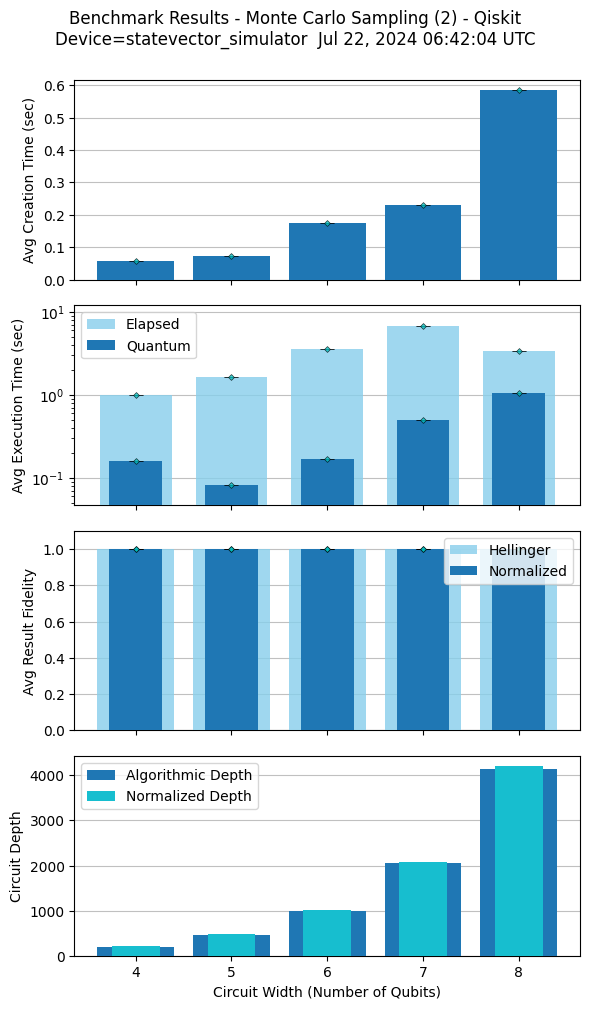

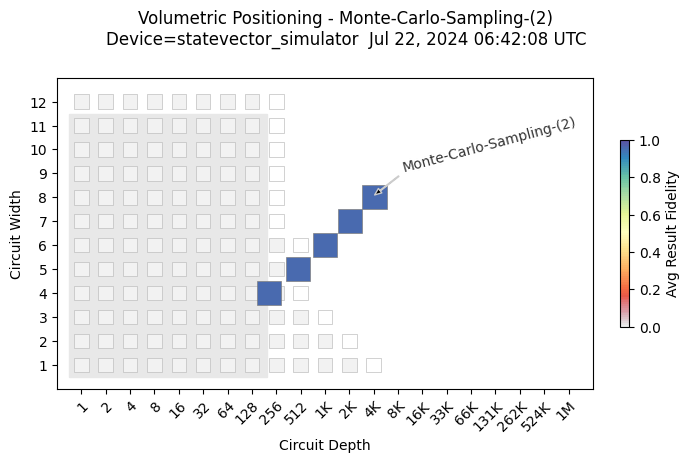

In [4]:
%run mc_benchmark.py

## $\zeta$ Verification

Need to validate the generation of the $u$-order polynomial approximation $\zeta$ such that  

$$\text{lim}_{u\rightarrow \infty} \ \ \ \zeta^{(u)}_c (f,x) =  \sin^{-1}\Bigg(\sqrt{c \big( f(x) - \frac{1}{2} \big) + \frac{1}{2}} \Bigg) $$

Then applying an intermediate gate $U_{\zeta}$ onto an objective qubit using order $u$ on $n$ qubits the following form:

$$U_{\zeta} |0\rangle = \cos(\zeta(x))|0\rangle + \sin(\zeta(x))|1\rangle$$

can be implemented using $n^{(1+u)}$ multi-controlled $R_y$ gates.


Measuring the probability of measuring the bit in the $|1\rangle$ state will be $\sin^2(\zeta)$, or the value $a$ determined by Amplitude Estimation,

$$a = c \big[ f(x) - \frac{1}{2} \big] + \frac{1}{2}$$

In [5]:
def arcsin_approx(f, x, epsilon, degree, c_star):
    zeta_ = functools.partial(zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    poly = Polynomial(polyfit(x, zeta_(x), degree))
    return poly

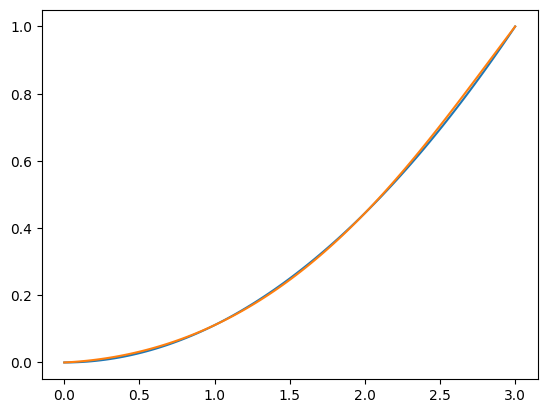

In [6]:
num_state_qubits_=2
epsilon_=0.05
degree_= 3
power =  2

c_star_ = (2*epsilon_)**(1/(degree_+1))
x_plot = np.linspace(0.0, 2**(num_state_qubits_) - 1, num=100)
x_eval = np.linspace(0.0, 2**(num_state_qubits_) - 1, num= degree_+1)
f_ = functools.partial(power_f, num_state_qubits=num_state_qubits_, power=power)


poly_ = arcsin_approx(f_, x_eval, epsilon_, degree_, c_star_)
def corrected_amplitudes(x):
    #return poly_(x)
    #return (np.sin(poly_(x))**2)
    return (((np.sin(poly_(x))**2) - 0.5) / c_star_) + 0.5

########

plt.plot(x_plot, f_(x_plot), label="f")
plt.plot(x_plot, corrected_amplitudes(x_plot), label=f"degree={degree_}")

## Polynomial Rotation Validation

<img src="../_common/images/poly_exp.png"  height="700" width="800" />

FIG. 1: Quantum circuit realizing the mapping $$|x\rangle |0\rangle \rightarrow |x\rangle \big(
(\cos(ζ(x)/2)|0\rangle + \sin(ζ(x)/2)|1\rangle\big)$$ 

for $ζ(x) = ax^2 + bx + c$ and $x ∈ {0, 1, 2, 3}$. Exploiting $x = 2q_1 +q_0$ and $q^2_i = q_i$ leads
to $ζ(x) = (4a + 2b)q_1 + 4aq_0q_1 + (a + b)q_0 + c$, which can be
directly mapped to a circuit. $R_y$ denotes a Y-rotation.

In [7]:
# Test coefficient list in the increasing degree; i.e. [a, b, c, ... {z}] for a + b x + c x^2 ... {z} x^n
num_q = 2
coef_list = [3, 1, 1]
poly = Polynomial(coef_list)
print(poly.coef)

print(binary_expansion(num_q, poly))

[3. 1. 1.]
{(): 3.0, (0,): 2.0, (1,): 6.0, (0, 1): 4.0}


## State-prep Circuit Verification

In [8]:
num_q = 3
t_d = {'101': 0, '000': 0.25, '011': 0.125, '100': 0.125, '001': 0.0, '010': 0.25, '110': 0.125, '111': 0.125}
u_d = uniform_dist(num_q)
m_d = {'000': 0.5, '001': 0.25, '010':0.25}

# Change to whatever distribution you like
dist = m_d

qr_ = QuantumRegister(num_q)
cr_ = ClassicalRegister(num_q)
qc_ = QuantumCircuit(qr_, cr_)

state_prep(qc_, qr_, dist, num_state_qubits=num_q)
qc_.measure(qr_, cr_)

from qiskit import execute, Aer
backend = Aer.get_backend("qasm_simulator")
job = execute(qc_, backend, shots=1000)
result = job.result()
counts = result.get_counts()
print('')
print(dist)

print(counts)
print(hellinger_fidelity(dist,counts))


{'000': 0.5, '001': 0.25, '010': 0.25}
{'001': 261, '000': 518, '010': 221}
0.975800970261973


In [9]:
def state_prep(qc, qr, target_dist, num_state_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = region_probs(target_dist, num_state_qubits)
    regions = r_probs.keys()
    r_norm = {}
    
    for r in regions:
        num_controls = len(r) - 1
        super_key = r[:num_controls]

        if super_key=='':
            r_norm[super_key] = 1
        elif super_key == '1':
            r_norm[super_key] = r_probs[super_key]
            r_norm['0'] = 1-r_probs[super_key]
        else:
            try:
                r_norm[super_key] = r_probs[super_key]
                
            except KeyError:
                r_norm[super_key] = r_norm[super_key[:num_controls-1]] - r_probs[super_key[:num_controls-1] + '1']
        
        
        norm = r_norm[super_key]
        p = 0
        if norm != 0:
            p = r_probs[r] / norm
        theta = -2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.ry(theta, num_state_qubits-1)
        else:
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.x(num_state_qubits-1 - k)
            
            controls = [qr[num_state_qubits-1 - i] for i in range(num_controls)]
            qc.mcry(theta, controls, qr[num_state_qubits-1 - num_controls], q_ancillae=None)
            
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.x(num_state_qubits-1 - k)

## F Circuit Verification

In [10]:
def f_on_objective(qc, qr, f, epsilon=0.05, degree=3):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_state_qubits = qc.num_qubits - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_state_qubits=num_state_qubits)
    zeta_ = functools.partial(zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x_eval = np.linspace(0.0, 2**(num_state_qubits) - 1, num= degree+1)
    poly = Polynomial(polyfit(x_eval, zeta_(x_eval), degree))
    
    b_exp = binary_expansion(num_state_qubits, poly)
    
    for controls in b_exp.keys():
        theta = 2*b_exp[controls]
        controls = list(controls)
        if len(controls)==0:
            qc.ry(-theta, qr[num_state_qubits])
        else:
            qc.mcry(-theta, [qr[i] for i in controls], qr[num_state_qubits], q_ancillae=None)

In [11]:
from qiskit import execute, Aer
backend = Aer.get_backend("qasm_simulator")

num_state_qubits_=4
epsilon_ = 0.05
degree_= 3
power =  1
c_star_ = (2*epsilon_)**(1/(degree_+1))

f_ = functools.partial(power_f, power=power)

x_vals = list(range(2**num_state_qubits_))
y_vals = []
f_vals = f_(x_vals, num_state_qubits_)

for i in x_vals:
    qr_ = QuantumRegister(num_state_qubits_+1)
    cr_ = ClassicalRegister(num_state_qubits_+1)
    qc_ = QuantumCircuit(qr_, cr_)
    
    b = bin(i)[2:].zfill(num_state_qubits_)[::-1]
    for q in range(len(b)):
        if b[q]=='1':
            qc_.x(q)
            
    f_on_objective(qc_, qr_, f_, epsilon_, degree_)
    qc_.measure(qr_, cr_)

    job = execute(qc_, backend, shots=1000)
    result = job.result()
    counts = result.get_counts()

    print(counts)
    try:
        print(i, '', b, '', counts['1'+b[::-1]]/1000)
        y_vals.append(counts['1'+b[::-1]]/1000)
    except KeyError:
        print(i, '', b, '', 0)
        y_vals.append(0)

        
y_corrected = []
for y in y_vals:
    y_corrected.append(((y - 0.5) / c_star_) + 0.5)

{'00000': 772, '10000': 228}
0  0000  0.228
{'10001': 262, '00001': 738}
1  1000  0.262
{'10010': 275, '00010': 725}
2  0100  0.275
{'10011': 321, '00011': 679}
3  1100  0.321
{'10100': 360, '00100': 640}
4  0010  0.36
{'10101': 425, '00101': 575}
5  1010  0.425
{'00110': 548, '10110': 452}
6  0110  0.452
{'00111': 517, '10111': 483}
7  1110  0.483
{'01000': 476, '11000': 524}
8  0001  0.524
{'01001': 440, '11001': 560}
9  1001  0.56
{'01010': 405, '11010': 595}
10  0101  0.595
{'11011': 595, '01011': 405}
11  1101  0.595
{'11100': 670, '01100': 330}
12  0011  0.67
{'11101': 696, '01101': 304}
13  1011  0.696
{'01110': 255, '11110': 745}
14  0111  0.745
{'01111': 216, '11111': 784}
15  1111  0.784


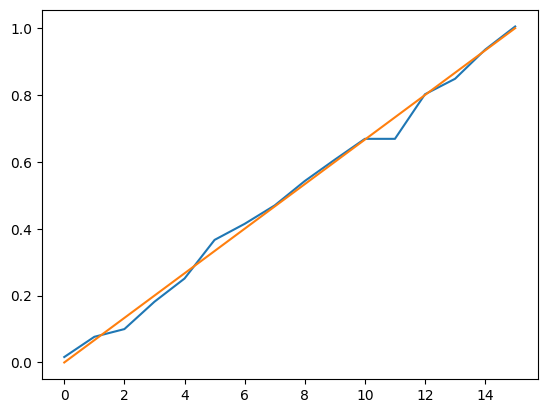

In [12]:
#plt.plot(x_vals, y_vals)
plt.plot(x_vals, y_corrected)
plt.plot(x_vals, f_vals)
print('')
plt.show()

## All together

In [13]:
dist = u_d
print(u_d)

{'000': 0.125, '001': 0.125, '010': 0.125, '011': 0.125, '100': 0.125, '101': 0.125, '110': 0.125, '111': 0.125}


In [14]:
num_state_qubits_= 3
num_ancillas = 6
epsilon_=0.05
degree_= 2
power =  2
c_star_ = (2*epsilon_)**(1/(degree_+1))

p = uniform_dist
dist = p(num_state_qubits_)

f_ = functools.partial(power_f, power=power)

qc_ = MonteCarloSampling(dist, f_, num_state_qubits_, num_ancillas, epsilon_, degree_)

backend = Aer.get_backend("qasm_simulator")
job = execute(qc_, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc_)

v_string = max(counts, key=counts.get)
v = int(v_string,2)
#print(v, v_string)

a = pow(np.sin(np.pi*v/pow(2,num_ancillas)),2)
a_est = ((a - 0.5)/c_star_) + 0.5

a_exact = actual_(dist, f_, num_state_qubits_)

print(a_est, a_exact)

NameError: name 'actual_' is not defined

In [ ]:
best_result = max(counts, key=counts.get)
v = int(best_result,2)
print(v, best_result)
    
#a_ = pow(np.cos(2*np.pi*v/pow(2,num_ancillas)),2)
#a_est = a_ 

best_result = max(counts, key=counts.get)
v = int(best_result,2)
a_int = pow(np.sin(np.pi*v/pow(2,num_ancillas)),2)
a_est = ((a_int - 0.5) / c_star_) + 0.5

a_exact = actual_(dist,f_,num_state_qubits_)
a_ex = ((a_exact - 0.5) * c_star_) + 0.5

print(a_est, a_exact)
print(a_int, a_ex)
print(counts)

In [ ]:
def actual_(dist, f_, num_state_qubits):
    s = 0
    _f = functools.partial(f_, num_state_qubits=num_state_qubits)
    for key in dist.keys():
        x = int(key,2)
        s += dist[key]*_f(x)
    return s

In [ ]:
def MonteCarloSampling(target_dist, f, num_state_qubits, num_ancillas, epsilon=0.05, degree=2):
    
    A_qr = QuantumRegister(num_state_qubits+1)
    A = QuantumCircuit(A_qr)
    
    state_prep(A, A_qr, target_dist, num_state_qubits)
    f_on_objective(A, A_qr, f, epsilon=epsilon, degree=degree)
    
    qc = AE_Subroutine(num_state_qubits, num_ancillas, A)
    
    return qc 

In [ ]:
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qc = QuantumCircuit(num_state_qubits+1, name=f"Q")
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc.x(num_state_qubits)
    qc.z(num_state_qubits)
    qc.x(num_state_qubits)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_state_qubits+1)])
        
    # S_0
    for i in range(num_state_qubits+1):
        qc.x(i)
    qc.h(num_state_qubits)
    
    qc.mcx([x for x in range(num_state_qubits)], num_state_qubits)
    
    qc.h(num_state_qubits)
    for i in range(num_state_qubits+1):
        qc.x(i)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_state_qubits+1)])
    
    # Create a gate out of the Q operator
    qc.to_gate(label='Q')
    
    # and also a controlled version of it
    Ctrl_Q_ = qc.control(1)
    
    # and return both
    return Ctrl_Q_, qc

In [ ]:
def AE_Subroutine(num_state_qubits, num_ancillas, A_circuit):
    ctr, unctr = Ctrl_Q(num_state_qubits, A_circuit)
    qr_state = QuantumRegister(num_state_qubits+1)
    qr_ancilla = QuantumRegister(num_ancillas)
    cr = ClassicalRegister(num_ancillas)
    qc_full = QuantumCircuit(qr_ancilla, qr_state, cr)
    
    qc_full.append(A_circuit, [qr_state[i] for i in range(num_state_qubits+1)])
    
    repeat = 1
    for j in range(num_ancillas):
        qc_full.h(qr_ancilla[j])
        for k in range(repeat):
            qc_full.append(ctr, [qr_ancilla[j]] + [qr_state[l] for l in range(num_state_qubits+1)])
        repeat *= 2
    
    qc_full.barrier()
    qc_full.append(QFT(num_qubits=num_ancillas, inverse=True), qr_ancilla)
    qc_full.barrier()
    qc_full.measure([qr_ancilla[m] for m in range(num_ancillas)], list(range(num_ancillas)))
    
    return qc_full